In [13]:
import numpy as np
import dolfinx
from dolfinx import fem, default_scalar_type, log
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import ufl
import pyvista
import matplotlib.pyplot as plt
from dolfinx.plot import vtk_mesh

L = 2.0
H = 1.0
Nx = 50
Ny = 50

# create the mesh
mesh = dolfinx.mesh.create_rectangle(MPI.COMM_WORLD, 
                                        points=((0.0,0.0),(L,H)), 
                                        n=(Nx,Ny),
                                        diagonal=dolfinx.mesh.DiagonalType.crossed)
# create function space
V = fem.VectorFunctionSpace(mesh, ("Lagrange", 1))

# material properties
nu = 0.3 # Poisson's ratio
E = 1 # Young's modulus
mu = dolfinx.fem.Constant(mesh,1.0) # shear modulus
lmbda = dolfinx.fem.Constant(mesh, dolfinx.default_scalar_type(2.0*mu*nu/(1.0-2.0*nu))) # Lame constant
K = lmbda * 2/3 *mu # bulk modulus

# strain
def epsilon(u):
    return 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)
# stress
def sigma(u):
    return lmbda * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2 * mu * epsilon(u)

def clamped_boundary(x):
    return np.isclose(x[0], 0)

fdim = mesh.topology.dim - 1
boundary_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, clamped_boundary)

u_D = np.array([0, 0], dtype=default_scalar_type)
bc = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, fdim, boundary_facets), V)

# homogeneous deformation bc
# bch = fem.dirichletbc(displacement, fem.locate_dofs_topological(V, fdim, boundary_facets), V)


B  = dolfinx.fem.Constant(mesh, dolfinx.default_scalar_type((0.0, 0.0)))  # Body force per unit volume
T = fem.Constant(mesh, default_scalar_type((0.2, 0.0)))

# Define variational problem
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
L = ufl.dot(T, v) * ufl.ds

# a2= ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
# L2 = ufl.inner(fem.Constant(mesh, (0.0, 0.0)), v) * ufl.ds


2024-04-01 23:52:57.174 ( 139.225s) [main            ]         graphbuild.cpp:395   INFO| Build local part of mesh dual graph
2024-04-01 23:52:57.193 ( 139.244s) [main            ]           ordering.cpp:203   INFO| GPS pseudo-diameter:(199) 9999-0
2024-04-01 23:52:57.198 ( 139.249s) [main            ]           Topology.cpp:901   INFO| Create topology
2024-04-01 23:52:57.199 ( 139.250s) [main            ]                MPI.cpp:166   INFO| Computing communication graph edges (using NBX algorithm). Number of input edges: 1
2024-04-01 23:52:57.199 ( 139.250s) [main            ]                MPI.cpp:237   INFO| Finished graph edge discovery using NBX algorithm. Number of discovered edges 1
2024-04-01 23:52:57.208 ( 139.260s) [main            ]          partition.cpp:233   INFO| Compute ghost indices
2024-04-01 23:52:57.208 ( 139.260s) [main            ]                MPI.cpp:99    INFO| Computing communication graph edges (using PCX algorithm). Number of input edges: 0
2024-04-01 23:5

2024-04-01 23:52:57.244 ( 139.295s) [main            ]                MPI.cpp:166   INFO| Computing communication graph edges (using NBX algorithm). Number of input edges: 0
2024-04-01 23:52:57.244 ( 139.295s) [main            ]                MPI.cpp:237   INFO| Finished graph edge discovery using NBX algorithm. Number of discovered edges 0
2024-04-01 23:52:57.244 ( 139.296s) [main            ]                MPI.cpp:166   INFO| Computing communication graph edges (using NBX algorithm). Number of input edges: 0
2024-04-01 23:52:57.244 ( 139.296s) [main            ]                MPI.cpp:237   INFO| Finished graph edge discovery using NBX algorithm. Number of discovered edges 0
2024-04-01 23:52:57.245 ( 139.296s) [main            ]                MPI.cpp:166   INFO| Computing communication graph edges (using NBX algorithm). Number of input edges: 0
2024-04-01 23:52:57.245 ( 139.296s) [main            ]                MPI.cpp:237   INFO| Finished graph edge discovery using NBX algorith

In [14]:
# create and solve linear problem
log.set_log_level(log.LogLevel.INFO)
problem = LinearProblem(a, L, bcs=[bc],petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

problem2 = LinearProblem(a2, L2, bcs=[bch],petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh2 = problem2.solve()

2024-04-01 23:52:58.157 ( 140.208s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-01 23:52:58.160 ( 140.211s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 1 - 2
2024-04-01 23:52:58.160 ( 140.211s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 1
2024-04-01 23:52:58.335 ( 140.386s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-01 23:52:58.337 ( 140.388s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 1 - 2
2024-04-01 23:52:58.337 ( 140.388s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 1


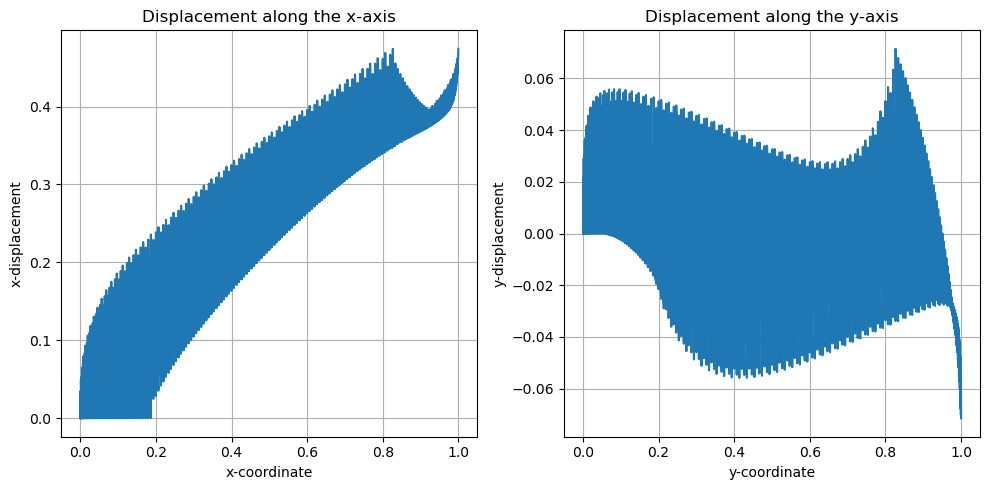

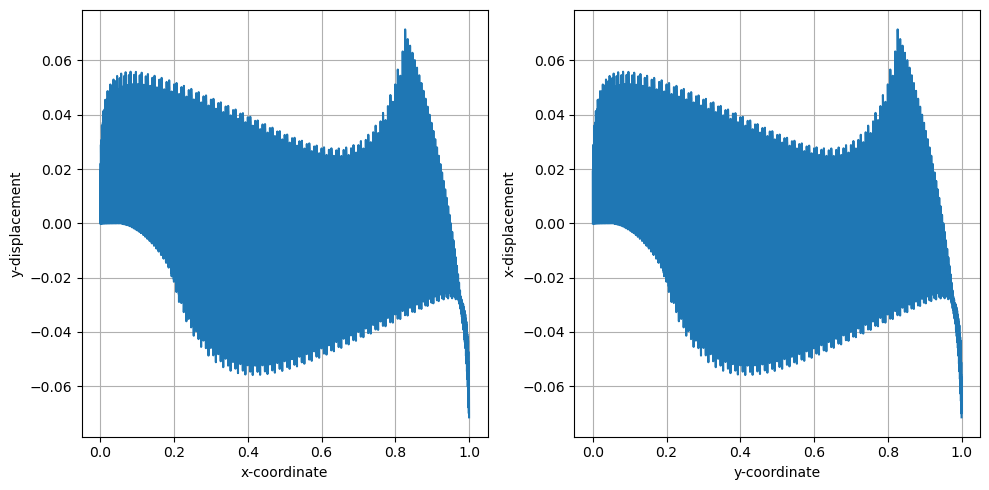

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Extract y-displacement from the array
y_displacement = uh.x.array[1::2]  # Every second value starting from index 1

# Extract x-displacement from the array
x_displacement = uh.x.array[::2]  # Every second value starting from index 0

Ny_intervals = len(y_displacement) - 1
Nx_intervals = len(x_displacement) - 1

# Create array for y-coordinates
y_coordinates = np.linspace(0, 1, Ny_intervals+1)  # Use Ny for the number of intervals along the y-direction
# Create array for x-coordinates
x_coordinates = np.linspace(0, 1, Nx_intervals+1)  # Use Nx for the number of intervals along the x-direction

# Plot displacement along the x-axis
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x_coordinates, x_displacement)
plt.xlabel('x-coordinate')
plt.ylabel('x-displacement')
plt.title('Displacement along the x-axis')
plt.grid(True)

# Plot displacement along the y-axis
plt.subplot(1, 2, 2)
plt.plot(y_coordinates, y_displacement)
plt.xlabel('y-coordinate')
plt.ylabel('y-displacement')
plt.title('Displacement along the y-axis')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot displacement along the x-axis
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x_coordinates, y_displacement)
plt.xlabel('x-coordinate')
plt.ylabel('y-displacement')
plt.grid(True)

# Plot displacement along the y-axis
plt.subplot(1, 2, 2)
plt.plot(y_coordinates, y_displacement)
plt.xlabel('y-coordinate')
plt.ylabel('x-displacement')
plt.grid(True)

plt.tight_layout()
plt.show()


In [4]:
# visualization using pyvista
pyvista.start_xvfb()

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid["u"] = uh.x.array.reshape((geometry.shape[0], 2))
actor_0 = p.add_mesh(grid, style="wireframe")
p.show_axes()
p.show()

DRI3 not available
failed to load driver: zink


Widget(value='<iframe src="http://localhost:34045/index.html?ui=P_0x7eb08d6b90f0_0&reconnect=auto" class="pyvi…

In [15]:
# visualization using pyvista
pyvista.start_xvfb()

# Create plotter and pyvista grid
p2 = pyvista.Plotter()
topology, cell_types, geometry = vtk_mesh(V)
grid2 = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid2["u"] = uh2.x.array.reshape((geometry.shape[0], 2))
actor_0 = p2.add_mesh(grid2, style="wireframe")
p2.show_axes()
p2.show()

DRI3 not available
failed to load driver: zink


Widget(value='<iframe src="http://localhost:34045/index.html?ui=P_0x7eb069498f10_6&reconnect=auto" class="pyvi…

In [6]:
# Reshape uh.x.array into a 2D array
displacement_array = uh.x.array.reshape((-1, 2))

# Extract displacement components
u_x = displacement_array[:, 0]
u_y = displacement_array[:, 1]

# Apply displacement to original mesh vertices
deformed_vertices = geometry.reshape(-1, 3) + np.column_stack((u_x, u_y, np.zeros_like(u_x)))

# Create a new PyVista mesh with the deformed vertices
deformed_mesh = pyvista.PolyData(deformed_vertices)

# Create plotter
p = pyvista.Plotter()

# Add deformed mesh (surface)
p.add_mesh(deformed_mesh, color="red", label="Deformed Mesh")

# Add original mesh (wireframe)
p.add_mesh(grid, style="wireframe", color="blue", label="Original Mesh")

# Show plot
p.show()

DRI3 not available
failed to load driver: zink


Widget(value='<iframe src="http://localhost:34045/index.html?ui=P_0x7eb058d67880_2&reconnect=auto" class="pyvi…

In [16]:
# Reshape uh.x.array into a 2D array
displacement_array = uh2.x.array.reshape((-1, 2))

# Extract displacement components
u_x = displacement_array[:, 0]
u_y = displacement_array[:, 1]

# Apply displacement to original mesh vertices
deformed_vertices = geometry.reshape(-1, 3) + np.column_stack((u_x, u_y, np.zeros_like(u_x)))

# Create a new PyVista mesh with the deformed vertices
deformed_mesh = pyvista.PolyData(deformed_vertices)

# Create plotter
p = pyvista.Plotter()

# Add deformed mesh (surface)
p.add_mesh(deformed_mesh, color="red", label="Deformed Mesh")

# Add original mesh (wireframe)
p.add_mesh(grid, style="wireframe", color="blue", label="Original Mesh")

# Show plot
p.show()

DRI3 not available
failed to load driver: zink


Widget(value='<iframe src="http://localhost:34045/index.html?ui=P_0x7eb044dc6ad0_7&reconnect=auto" class="pyvi…

In [8]:
# pyvista.start_xvfb()
# plotter = pyvista.Plotter()
# plotter.open_gif("deformation.gif", fps=3)

# topology, cells, geometry = plot.vtk_mesh(u.function_space)
# function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)

# values = np.zeros((geometry.shape[0], 3))
# values[:, :len(u)] = u.x.array.reshape(geometry.shape[0], len(u))
# function_grid["u"] = values
# function_grid.set_active_vectors("u")

# # Warp mesh by deformation
# warped = function_grid.warp_by_vector("u", factor=1)
# warped.set_active_vectors("u")

# # Add mesh to plotter and visualize
# actor = plotter.add_mesh(warped, show_edges=True, lighting=False, clim=[0, 10])

# # Compute magnitude of displacement to visualize in GIF
# Vs = fem.FunctionSpace(mesh, ("Lagrange", 1))
# magnitude = fem.Function(Vs)
# us = fem.Expression(ufl.sqrt(sum([u[i]**2 for i in range(len(u))])), Vs.element.interpolation_points())
# magnitude.interpolate(us)
# warped["mag"] = magnitude.x.array

In [9]:
# log.set_log_level(log.LogLevel.INFO)
# tval0 = -1.5
# for n in range(1, 10):
#     T.value[1] = n * tval0
#     num_its, converged = solver.solve(u)
#     assert (converged)
#     u.x.scatter_forward()
#     print(f"Time step {n}, Number of iterations {num_its}, Load {T.value}")
#     function_grid["u"][:, :len(u)] = u.x.array.reshape(geometry.shape[0], len(u))
#     magnitude.interpolate(us)
#     warped.set_active_scalars("mag")
#     warped_n = function_grid.warp_by_vector(factor=1)
#     plotter.update_coordinates(warped_n.points.copy(), render=False)
#     plotter.update_scalar_bar_range([0, 10])
#     plotter.update_scalars(magnitude.x.array)
#     plotter.write_frame()

# plotter.close()